In [57]:
import numpy as np
import cvxpy as cp
import scipy.io as sio

from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

import pickle

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

import os
import random
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [58]:
torch.cuda.is_available()

True

In [59]:
def haar_wavelet_matrix(n):

    if np.log2(n) % 1 > 0:
        raise ValueError("n must be a power of 2")
    
    # Initialize the Haar basis matrix
    haar_matrix = np.zeros((n, n))
    
    # First row: the scaling function (constant average)
    haar_matrix[0, :] = np.ones(n) / np.sqrt(n)
    
    k = 1  # Keeps track of the row index
    for level in range(int(np.log2(n))):
        step = 2**level
        for j in range(step):
            # High-pass (difference) filter at this scale
            for i in range(0, n, 2*step):
                haar_matrix[k, i:i+step] = 1.0 / np.sqrt(step)
                haar_matrix[k, i+step:i+2*step] = -1.0 / np.sqrt(step)
            k += 1
    
    return haar_matrix

# Generate the Haar basis matrix for 256 components
n = 256
haar_matrix = haar_wavelet_matrix(n)

In [60]:
haar_matrix = np.apply_along_axis(lambda x: x / np.linalg.norm(x), axis = 1, arr = haar_matrix)
haar_matrix = haar_matrix.T

In [61]:
D = np.hstack([haar_matrix, np.eye(256)])
D = torch.from_numpy(D.astype(np.float32))

# Image denoising via sparse representation 

In [62]:
from models.ALISTA import ALISTA
from models.ALDCISTA import ALDC_ISTA

from utils.train import layerwise_train_U, layerwise_train_DC_U

In [63]:
class ImagePatchDataset(Dataset):
    def __init__(self, folder_path, patch_size=(16, 16), total_patches=None, transform=None, SNR=None):
        self.folder_path = folder_path
        self.patch_size = patch_size
        self.transform = transform
        self.image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(('png', 'jpg', 'jpeg'))]
        self.num_images = len(self.image_files)
        self.patches_per_image = total_patches // self.num_images if total_patches else None
        self.SNR = SNR
        
    def __len__(self):
        if self.patches_per_image:
            return self.patches_per_image * self.num_images
        return sum((image_width // self.patch_size[0]) * (image_height // self.patch_size[1]) 
                   for image_path in self.image_files 
                   for image_width, image_height in [Image.open(image_path).size])

    def __getitem__(self, idx):
        image_idx = idx % self.num_images  
        image_path = self.image_files[image_idx]
        image = Image.open(image_path).convert('L')  

        # Calculate the grid of patches for the image
        image_width, image_height = image.size
        grid_cols = image_width // self.patch_size[0]
        grid_rows = image_height // self.patch_size[1]

        # Compute patch coordinates from idx
        patch_idx = idx // self.num_images  
        row = patch_idx // grid_cols
        col = patch_idx % grid_cols

        x = col * self.patch_size[0]
        y = row * self.patch_size[1]

        patch = image.crop((x, y, x + self.patch_size[0], y + self.patch_size[1]))

        # Convert patch to numpy array for noise addition
        patch_np = np.array(patch, dtype=np.float32) / 255 

        # Add Gaussian noise
        if self.SNR is not None:
            patch_np = self.add_gaussian_noise(patch_np)

        if self.transform:
            patch_np = self.transform(patch_np)

        return patch_np

    def add_gaussian_noise(self, patch):
        # Signal and noise calculation
        signal_power = np.mean(patch ** 2)
        noise_power = signal_power / (10 ** (self.SNR / 10))
        noise = np.random.normal(0, np.sqrt(noise_power), patch.shape)
        noisy_patch = patch + noise
        return noisy_patch

In [64]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Lambda(lambda x: x.view(-1).to(torch.float32))  
])

# Parameters
train_folder_path = r"C:\Users\Leonardo\Documents\GitHub\ModelBasedDL4SCA\Sparse analysis\real_data\images\train"
val_folder_path = r"C:\Users\Leonardo\Documents\GitHub\ModelBasedDL4SCA\Sparse analysis\real_data\images\val"
test_folder_path = r"C:\Users\Leonardo\Documents\GitHub\ModelBasedDL4SCA\Sparse analysis\real_data\images\test"

patch_size = (16, 16)
total_patches = 10000  # Control the total number of patches in the dataset
batch_size = 50
shuffle = False

# Create dataset and dataloader
train_dataset = ImagePatchDataset(train_folder_path, patch_size=patch_size, total_patches=10000, transform=transform, SNR = None)
val_dataset = ImagePatchDataset(val_folder_path, patch_size=patch_size, total_patches=1000, transform=transform, SNR = None)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)


In [65]:
test_dataset = ImagePatchDataset(test_folder_path, patch_size=patch_size, total_patches=1000, transform=transform, SNR = None)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

In [66]:
all_train_patches = []
for patches in train_dataloader:
    all_train_patches.append(patches.numpy())

all_train_patches = np.concatenate(all_train_patches, axis=0)

all_val_patches = []
for patches in val_dataloader:
    all_val_patches.append(patches.numpy())

all_val_patches = np.concatenate(all_val_patches, axis=0)

all_test_patches = []
for patches in test_dataloader:
    all_test_patches.append(patches.numpy())

all_test_patches = np.concatenate(all_test_patches, axis=0)

___________

___________

# Unsupervised version

In [23]:
all_train_patches.shape

(10000, 256)

In [24]:
class SparseCodingDataset(Dataset):
    def __init__(self, patches, snr_db):
        self.patches = torch.tensor(patches, dtype=torch.float32)  
        self.snr_db = snr_db

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        # Get the clean patch
        clean_patch = self.patches[idx]

        # Generate noise
        noise = self._generate_noise(clean_patch)

        # Create the noisy patch
        noisy_patch = clean_patch + noise

        return clean_patch, noisy_patch

    def _generate_noise(self, clean_patch):
        # Calculate the signal power
        signal_power = clean_patch.norm() ** 2 / clean_patch.shape[0]

        # Calculate the noise power using the desired SNR
        snr_linear = 10 ** (self.snr_db / 10)
        noise_power = signal_power / snr_linear

        # Generate Gaussian noise
        noise = torch.randn(clean_patch.shape) * noise_power.sqrt()

        return noise

In [28]:
train_dataset = SparseCodingDataset(all_train_patches, 20)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

In [29]:
val_dataset = SparseCodingDataset(all_val_patches, 20)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=True)

In [ ]:
model_1 = ALISTA(torch.clone(D), 1, T = 16)
layerwise_train_U(model_1, train_dataloader, val_dataloader, 'ALISTA', lr = 3e-3, ft_lr = 3e-7, verbose=True)

In [ ]:
model_2 = ALDC_ISTA(torch.clone(D), 'EXP', 1, T = 16, W = torch.clone(model_1.W).to('cuda:0'))
layerwise_train_DC_U(model_2, train_dataloader, val_dataloader, 'AL-DC-ISTA', 'EXP', lr = 3e-3, ft_lr = 3e-7, verbose=True)

In [ ]:
model_3 = ALDC_ISTA(torch.clone(D), 'PNEG', 1, T = 16, W = torch.clone(model_1.W).to('cuda:0'))
layerwise_train_DC_U(model_3, train_dataloader, val_dataloader, 'AL-DC-ISTA', 'PNEG', lr = 3e-3, ft_lr = 3e-7, verbose=True)

In [ ]:
model_4 = ALDC_ISTA(torch.clone(D), 'SCAD', 1, T = 16, W = torch.clone(model_1.W).to('cuda:0'))
layerwise_train_DC_U(model_4, train_dataloader, val_dataloader, 'AL-DC-ISTA', 'SCAD', lr = 3e-4, ft_lr = 3e-7, verbose=True)

In [21]:
torch.save(model_1.state_dict(), "model_1_REAL_weights.pth")
torch.save(model_2.state_dict(), "model_2_REAL_weights.pth")
torch.save(model_3.state_dict(), "model_3_REAL_weights.pth")
torch.save(model_4.state_dict(), "model_4_REAL_weights.pth")

In [31]:
model_4 = ALDC_ISTA(torch.clone(D), 'SCAD', 1, T = 16, W = torch.clone(model_1.W).to('cuda:0'))
model_3 = ALDC_ISTA(torch.clone(D), 'PNEG', 1, T = 16, W = torch.clone(model_1.W).to('cuda:0'))
model_2 = ALDC_ISTA(torch.clone(D), 'EXP', 1, T = 16, W = torch.clone(model_1.W).to('cuda:0'))

In [32]:
model_1.load_state_dict(torch.load('model_1_REAL_weights.pth'))
model_2.load_state_dict(torch.load('model_2_REAL_weights.pth'))
model_3.load_state_dict(torch.load('model_3_REAL_weights.pth'))
model_4.load_state_dict(torch.load('model_4_REAL_weights.pth'))

<All keys matched successfully>

In [72]:
def reconstruction_psnr(model, D, test_set, max_pixel_value=1):
    # Reset the losses accumulator
    total_loss = 0

    # Iterate over test_set
    with torch.no_grad():
        for (Y, Y_noisy) in test_set:
            Y_noisy = Y_noisy.to(model.device)
            Y = Y.to(model.device)

            # Forward pass to get the reconstructed signal
            S_hat = model.forward(y=Y_noisy, its=None, S=None)

            # Calculate reconstruction loss (MSE)
            mse = F.mse_loss(Y.T, D.to(model.device) @ S_hat.T, reduction="sum") / Y.numel()
            total_loss += mse.item()  # Accumulate MSE

    # Calculate the average MSE
    avg_mse = total_loss / len(test_set)

    # Avoid division by zero
    if avg_mse == 0:
        return float('inf')  # If MSE is 0, PSNR is infinite (perfect reconstruction)

    # Calculate PSNR in dB
    psnr = 10 * torch.log10(torch.tensor(max_pixel_value**2).to(model.device) / avg_mse)

    return psnr.item()  # Return as a Python float

In [73]:
SNRs = np.arange(14,31,2)

reconstruction_errors = {
    SNR : {
        'ALISTA':0,
        'AL-DC-ISTA-EXP':0,
        'AL-DC-ISTA-PNEG':0,
        'AL-DC-ISTA-SCAD':0
} for SNR in SNRs}

for SNR in tqdm(SNRs):
        
    test_dataset = SparseCodingDataset(all_test_patches, SNR)
    test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=True)

    reconstruction_errors[SNR]['ALISTA'] = reconstruction_psnr(model_1, D, test_dataloader)
    reconstruction_errors[SNR]['AL-DC-ISTA-EXP'] = reconstruction_psnr(model_2, D, test_dataloader)
    reconstruction_errors[SNR]['AL-DC-ISTA-PNEG'] = reconstruction_psnr(model_3, D, test_dataloader)
    reconstruction_errors[SNR]['AL-DC-ISTA-SCAD'] = reconstruction_psnr(model_4, D, test_dataloader)

100%|██████████| 9/9 [00:06<00:00,  1.47it/s]


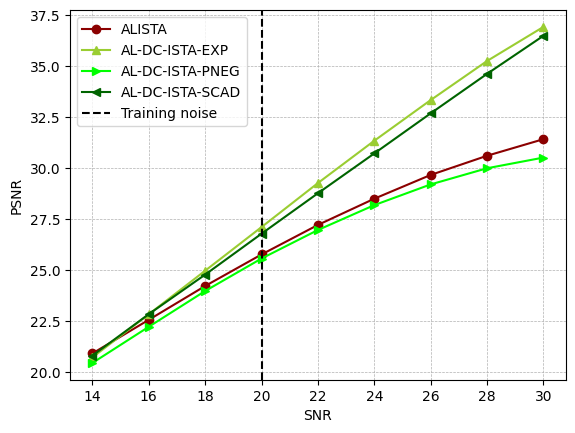

In [77]:
models = [
    'ALISTA',
    'AL-DC-ISTA-EXP',
    'AL-DC-ISTA-PNEG',
    'AL-DC-ISTA-SCAD'
]

colors = [
    'darkred',
    'yellowgreen',
    'lime',
    'darkgreen'
]

markers = [
    'o',
    '^',
    '>',
    '<'
]

for i, model_ in enumerate(models):
    plt.plot(SNRs, [reconstruction_errors[SNR][model_] for SNR in SNRs], label = model_, color = colors[i], marker = markers[i])

plt.xticks(SNRs)
plt.axvline(x=20, color='black', label='Training noise', linestyle='--')

plt.ylabel('PSNR')
plt.xlabel('SNR')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()